In [1]:
#Convex MPC Stationkeeping for L2 Halo Orbit around L2 
# Halo Orbit generated through a differential corrector 

In [2]:
#import the packages from the local environment
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/cvx-mpc-stationkeeping`


In [3]:
#packages used 
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools
using DelimitedFiles

In [4]:
include("../src/dynamics.jl")
include("../src/parameters.jl")
include("../src/integrate.jl")
include("../src/solve.jl")

solve_opt (generic function with 1 method)

In [5]:
Earth_Moon = ThreeBodySystem_EarthMoon()

ThreeBodySystem(0.01215, 0.98785, 0.01215, [-0.01215, 0.0, 0.0], [0.98785, 0.0, 0.0], 385000.0, 4.349129868518112, 88523.45449302066, 20354.29089708545, [0.8369180073169304, 0.0, 0.0, 0.0, 0.0, 0.0], [1.1556799130947355, 0.0, 0.0, 0.0, 0.0, 0.0])

In [6]:
#use a richardson expansion as the initial guess for the differential corrector 
#saved as a .txt

#this reference trajectory was obtained through ThreeBodyProblem.jl
#halo from richardson expansion
richardson = readdlm("../refs/richardsonL2.txt", '\t', Float64, '\n')'

#period of the halo (in cr3bp units)
T = 3.4071472466192527

#period in days
T_scaled = T*Earth_Moon.time_scale

#initial condition in CR3BP units
x0_L2 = richardson[:,1]

#scaled initial condition
x0_L2_scaled = [x0_L2[1:3]*Earth_Moon.position_scale; x0_L2[4:6]*Earth_Moon.velocity_scale]

6-element Vector{Float64}:
 431249.946141646
      0.0
   5642.062948909701
      0.0
  15342.188285037404
      0.0

In [7]:
Earth_Moon.acceleration_scale 

20354.29089708545

In [8]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_in = dynamics_integrate(Earth_Moon ,x_0_stm, T_scaled)

all_state_in, stm_in, sol_t_in = get_state_stm(solution_in)

([431249.946141646 431249.9461444589 … 369544.74912909867 369665.9710674015; 0.0 2.1072953725303933 … -45031.76538735194 -45157.53537524888; … ; 15342.188285037404 15342.188246755026 … -2527.477147320156 -1571.3827010368555; 0.0 -0.23903800908705172 … 2308.451334796891 2425.0874238384185], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.00000000622429 5.594567641213317e-14 … 4.337843062628147e-9 3.924109594110078e-14; -2.434276316857394e-14 0.9999999975890765 … 0.0001373529858999031 1.8119307154423863e-19; … ; -5.316833039735577e-10 -3.510551179617628e-5 … 0.999999995594267 5.2767129716926075e-15; 1.2480045464823515e-5 2.5469638239204106e-10 … 4.136769856380186e-14 0.9999999971840383;;; 1.0000000249515597 4.4903309225312285e-13 … 1.7389284798030495e-8 3.14958220963991e-13; -1.9538071544537643e-13 0.999999990335235 … 0.00027500592068671945 2.9117718373904653e-18; … ; -2.1313800807912153e-9 -7.028768607178565e-5 … 0.9999999823385622 4.2352132190747765

In [9]:
stm_in 

6×6×232 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0

[:, :, 2] =
  1.0           5.59457e-14   8.57086e-10  …  4.33784e-9   3.92411e-14
 -2.43428e-14   1.0          -6.38439e-15     0.000137353  1.81193e-19
  8.57086e-10   1.16611e-14   1.0             1.42049e-18  0.000137353
  9.0632e-5     1.22194e-9    1.248e-5        6.31634e-5   8.57086e-10
 -5.31683e-10  -3.51055e-5   -1.39445e-10     1.0          5.27671e-15
  1.248e-5      2.54696e-10  -4.10033e-5   …  4.13677e-14  1.0

[:, :, 3] =
  1.0           4.49033e-13   3.43583e-9   …  1.73893e-8   3.14958e-13
 -1.95381e-13   1.0          -5.12426e-14     0.000275006  2.91177e-18
  3.43583e-9    9.35947e-14   1.0             2.28273e-17  0.000275006
  0.000181462   4.89844e-9    2.49873e-5      0.000126465  3.43583e-9
 -2.13138e-9   -7.02877e-5   -5.58998e-10     1.0     

In [10]:
#this is not the same...
initial_norm = all_state_in[:,end] - all_state_in[:,1]

6-element Vector{Float64}:
 -61583.97507424449
 -45157.53537524888
 -10110.510441661956
   2028.194053160223
 -16913.57098607426
   2425.0874238384185

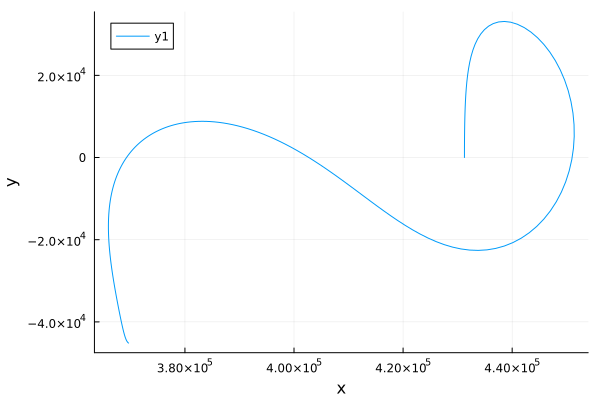

In [11]:
#If we integrate the richardson expansion on the CR3bp dynamics, it is not completely periodic because it is only an approximation 
#this is a plot of the integrated orbit

plot(all_state_in[1,:], all_state_in[2,:], xlabel="x", ylabel="y")

In [12]:
#the purpose of the differential corrector is to make the initial and final state of the orbit the same subject to some tolerance

#fix the richardson expansion guess with a single shooting differential corrector
function differential_corrector(system, x_0_stm, Tp)
    
    #this is the final time it converges to
    T_f = 0

    #Iterate to bring the δx at T/2 to the desired state
    max_iters = 1000

    #keep z0 fixed and change only x0 and y_dot_0
    for i=1:max_iters
    #for i=1:100

        solution = diff_solve(system, x_0_stm, Tp)

        #this is the state, STM, and time when y crosses the XZ plane 
        all_state, stm, sol_t = get_state_stm(solution)

        #display(stm)

        T2_state = all_state[:,end]

        #T2_state -> x,y,z, xdot, ydot, zdot
        #desired xdot an xzdot
        xz_d = [0, 0]

        rv = T2_state[1:6]

        rv_dot = three_body_prob_dynamics_scaled(system, rv)

        #desired state subtracted by state at t/2
        δxz = xz_d - [T2_state[4], T2_state[6]]

        #subset of the state transition matrix

        #all 6 variables 
        #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

        #to change x and ydot 

        #keep z0 constant
        #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

        #keep x0 constant
        stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
        dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


        #println("this is stm s: ")
        #println(stm_s)


        #keep y0 constant
        #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]

        delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        
        #println("THIS IS CONDITION NUMBER")
        #println(cond((stm_s - dy/rv_dot[2])))

        #delta_x0 = stm_s\δxz

        #update the initial state

        #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
        x_0_stm[3] = x_0_stm[3] + delta_x0[1]
        x_0_stm[5] = x_0_stm[5] + delta_x0[2]

        #x_0_stm[1:6] = x_0_stm[1:6] + delta
        #when delta is below a set tolerance we are done

        println("residual: ", δxz)
        
        #loosen up the tolerance bc of the scaling of the problem
        if norm(δxz) < 1e-6

            #this is the total time, but we use it to ensure we have enough time to find where
            #y crosses the xz plane
            #print("this is sol t: ", sol_t)
            #updating time
                    
            T_f = sol_t[end]*2
            break
        end

    end
    
    corrected_solution = dynamics_integrate(system, x_0_stm, T_f)

    all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
    return all_state_final, stm_final, sol_t_final, corrected_solution
    
end

differential_corrector (generic function with 1 method)

In [13]:
#run the differential corrector to get the corrected solution
all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(Earth_Moon, x_0_stm, T_scaled)

residual: [1643.9519839324487, -191.4988002731686]
residual: [2.5062654060160137, 35.414091821322586]
residual: [-495.1171688605523, 60.688781643238784]
residual: [-24.375558852836726, 8.506875803296856]
residual: [-110.46860206507704, 9.540111536783268]
residual: [-13.136193716304701, 1.758026940039784]
residual: [-14.47295436376987, 1.0122384454524755]
residual: [-1.5051816256491617, 0.1252862858144221]
residual: [-0.11466721336305255, 0.007759735519665084]
residual: [-0.0002584322764384862, 1.3541399399075671e-5]
residual: [-4.466341804239009e-6, -1.6699838992584847e-7]
residual: [-1.7181652133684486e-6, -6.467597166466907e-8]
residual: [4.390998454090687e-7, 1.6642285394796388e-8]


([431249.946141646 431249.94614368404 … 431250.7570701569 431249.9459525911; 0.0 2.118659307545513 … -1332.0877095001688 0.0002245328881018195; … ; 15649.016257820032 15649.016219624365 … 15633.915771830501 15649.016342283901; 0.0 -0.09679765124423992 … 60.838081487480196 -7.527633835777027e-6], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.746812490061226e-14 … 4.2144974216198e-9 1.5618037605153313e-14; -2.178985779599666e-14 0.9999999976191183 … 0.00013538610167654265 7.747337710088622e-20; … ; -4.828381381064227e-10 -3.5171730170269434e-5 … 0.9999999956810306 2.28896100118786e-15; 5.112455571955675e-6 1.0493438156541656e-10 … 1.6653248151092917e-14 0.9999999971499303;;; 1.0000000255866435 4.817924242782896e-13 … 1.739273010437185e-8 1.309361013432194e-13; -1.8267845868207107e-13 0.9999999901743841 … 0.000275033162472087 1.3194605279971914e-18; … ; -1.9926156055396843e-9 -7.145040750929283e-5 … 0.9999999821761268 1.91898386168

In [14]:
all_state_final 

6×133 Matrix{Float64}:
     4.3125e5      4.3125e5   …      4.31251e5      4.3125e5
     0.0           2.11866       -1332.09           0.000224533
  2286.77       2286.77           2284.18        2286.77
     0.0           0.0301068       -19.167         -0.000128932
 15649.0       15649.0           15633.9        15649.0
     0.0          -0.0967977  …     60.8381        -7.52763e-6

In [15]:
#due to difference in package versions, the reference trajectory in the paper and in this notebook are different by small amounts. However, this affects the solution in the end
#to replicate the results from the paper, use the following trajectory as the reference in the /refs folder for one revolution and do not use the differential corrector

#all_state_final = readdlm("moon_reference_paper.txt", ',')

#however, performance of the differential corrector and overall algorithm is better with the new version

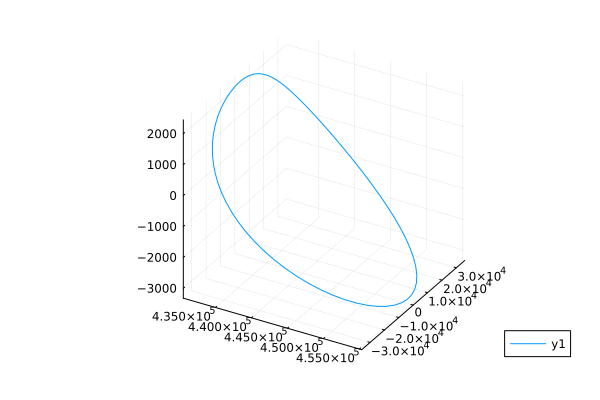

In [16]:
#this is the halo after the differential corrector 
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [17]:
all_state_final[:,1] 

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.773235491115
      0.0
  15649.016257820032
      0.0

In [18]:
#Check when the orbit leaves
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(Earth_Moon, x_0_stm, 3.5*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([431249.946141646 431249.94614368404 … 443246.7711365753 442751.7573693194; 0.0 2.118659307545513 … 4813.497828788193 3764.0793835602103; … ; 15649.016257820032 15649.016219624365 … -11412.46319839597 -11235.50377184583; 0.0 -0.09679765124423992 … 186.8916600300979 236.2180411772976], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.746812490061226e-14 … 4.2144974216198e-9 1.5618037605153313e-14; -2.178985779599666e-14 0.9999999976191183 … 0.00013538610167654265 7.747337710088622e-20; … ; -4.828381381064227e-10 -3.5171730170269434e-5 … 0.9999999956810306 2.28896100118786e-15; 5.112455571955675e-6 1.0493438156541656e-10 … 1.6653248151092917e-14 0.9999999971499303;;; 1.0000000255866435 4.817924242782896e-13 … 1.739273010437185e-8 1.309361013432194e-13; -1.8267845868207107e-13 0.9999999901743841 … 0.000275033162472087 1.3194605279971914e-18; … ; -1.9926156055396843e-9 -7.145040750929283e-5 … 0.9999999821761268 1.9189838616871862e-14;

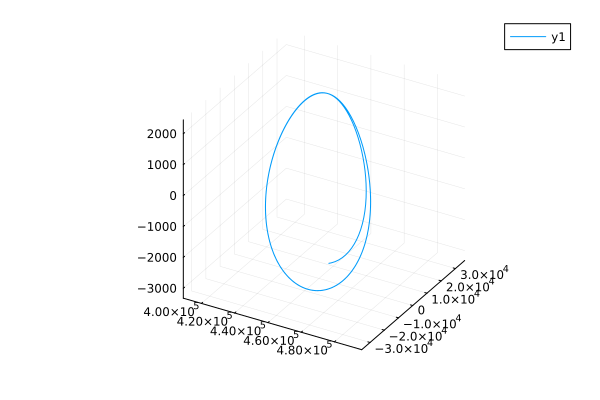

In [19]:
#the orbit after 3.5 revs 
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

In [20]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [21]:
nx = 6 #number of states
nu = 3 #number of controls 

N_period = 41  #41 knot points per period per period

#the first state repeats with the last state
N_h = 81 #horizon 2 periods

#timestep 
Δt = (sol_t_final[end]/(N_period-1))

0.3713042891751578

In [22]:
#variables to save all the dynamics jacobians this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [23]:
#this is the corrected period from the differential corrector
T_corrected = sol_t_final[end]

14.852171567006312

In [24]:
#create even timesteps along the horizon 
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [25]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [26]:
#get the reference trajectory and state transition matrices at the correct times along the horizon 
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = full_solution(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(full_solution(horizon).u[k][7:end], (6,6)) 
        
end

In [27]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
  0.5935997918584431
 -0.6423214978311852
  0.013967758702090721
  0.4049742938777418
 -0.265176962188159
  0.023329857891549916

In [28]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [29]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy
for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end

In [30]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642321   -0.611253   -0.574696   -0.534157      -0.666939    -0.642321
  0.0139678   0.0196799   0.0247411   0.028827       0.00797907   0.0139678
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233299   0.0246806   0.0244821   0.0229327  …   0.0205333    0.0233299

In [31]:
#save the manifolds when perturbation is added 
all_manifolds_plus = Matrix{Float64}[]

#save the manifolds when perturbation is subtracted 
all_manifolds_minus = Matrix{Float64}[]

Matrix{Float64}[]

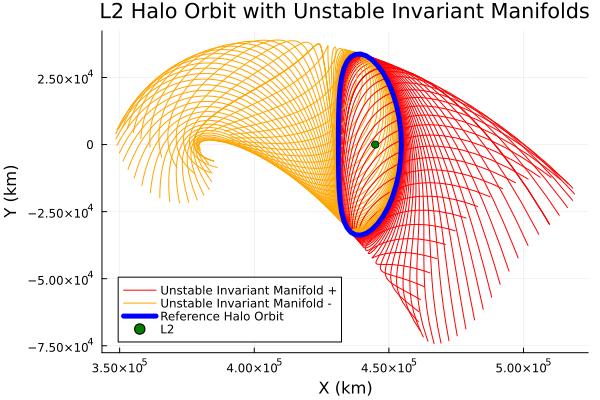

In [32]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left

#epsilon multiplied by the perturbation when finding the manifolds 
epz = 3

plot(reference_trajectory[1,:], reference_trajectory[2,:], label=nothing)

all_state_mplus = 0

all_state_mminus = 0
for i=1:N_period
 
    initial_state_plus = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    initial_state_minus = reference_trajectory[:,i] - epz.*[unstable_directions[1:3,i];zeros(3)]

    inv_manifold_plus = just_dynamics_integrate(Earth_Moon, initial_state_plus, 1.5*sol_t_final[end])

    inv_manifold_minus = just_dynamics_integrate(Earth_Moon, initial_state_minus, 1.45*sol_t_final[end])

    all_state_mplus = get_state(inv_manifold_plus)

    all_state_mminus = get_state(inv_manifold_minus)
    

    push!(all_manifolds_plus, all_state_mplus)
    push!(all_manifolds_minus, all_state_mminus)


    plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label=nothing)
    plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label=nothing)

end


plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label = "Unstable Invariant Manifold +")
plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label = "Unstable Invariant Manifold -")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Halo Orbit", linewidth = 5, xlabel = "X (km)", ylabel = "Y (km)", color="blue")
orbit_manifolds = scatter!([Earth_Moon.XL2[1]*Earth_Moon.position_scale], [0], markercolor = "green", label = "L2", legend=true, title = "L2 Halo Orbit with Unstable Invariant Manifolds")

In [33]:
#get the discrete dynamics jacobians for the entire reference trajectory along the knot points
for i=1:N_period

    all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(Earth_Moon, x_, zeros(3)), reference_trajectory[:,i])


    all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(Earth_Moon, reference_trajectory[:,i], u_), zeros(3))
    
    
end

In [34]:
#our horizon is 2 revolutions, therefore we need jacobians along the entire horizon
#will concatenate jacobians for two periods

all_Ad_1 = cat(all_Ad, all_Ad[:,:,2:end], dims=3)
all_Bd_1 = cat(all_Bd, all_Bd[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  0.0692974    0.00396111  2.93346e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93346e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89268e-5  0.36868

[:, :, 2] =
  0.0692656    0.00402781  2.63572e-5
 -0.00381906   0.0685871   4.37094e-6
  2.63572e-5   4.37094e-6  0.0686965
  0.374737     0.0330256   0.000274269
 -0.030512     0.367682    3.99156e-5
  0.000269826  6.31596e-5  0.368787

[:, :, 3] =
  0.0692132    0.00407449  2.14464e-5
 -0.00377237   0.068625    5.75986e-6
  2.14464e-5   5.75986e-6  0.0687109
  0.374151     0.0334585   0.00021943
 -0.0300649    0.368102    5.32538e-5
  0.000214041  7.17614e-5  0.368954

;;; … 

[:, :, 79] =
  0.0692656     0.00381945   2.63732e-5
 -0.00402742    0.068587    -4.35714e-6
  2.63732e-5   -4.35714e-6   0.0686965
  0.374973      0.0308243    0.000292584
 -0.0327187     0.367509    -5.26963e-5
  0.000296048  -2.75461e-5   0.368724

[

In [35]:
#compute backward ricatti recursion

#cost to go matrices for 16 revs
P = zeros((6,6,N_period+((N_period-1)*15))) #size state x state (6x6) 
K = zeros((3,6,N_period+((N_period-1)*15))) #size control x state (3x6)

#state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-3

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-3

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e3

3×3 Matrix{Float64}:
 1000.0     0.0     0.0
    0.0  1000.0     0.0
    0.0     0.0  1000.0

In [36]:
#variable to concatenate 16 sets of jacobians for 16 revolutions. this is to compute the recursion until we get a periodic pattern
all_Ad_16 = all_Ad
all_Bd_16 = all_Bd

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.0692974    0.00396111  2.93346e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93346e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89268e-5  0.36868

[:, :, 2] =
  0.0692656    0.00402781  2.63572e-5
 -0.00381906   0.0685871   4.37094e-6
  2.63572e-5   4.37094e-6  0.0686965
  0.374737     0.0330256   0.000274269
 -0.030512     0.367682    3.99156e-5
  0.000269826  6.31596e-5  0.368787

[:, :, 3] =
  0.0692132    0.00407449  2.14464e-5
 -0.00377237   0.068625    5.75986e-6
  2.14464e-5   5.75986e-6  0.0687109
  0.374151     0.0334585   0.00021943
 -0.0300649    0.368102    5.32538e-5
  0.000214041  7.17614e-5  0.368954

;;; … 

[:, :, 39] =
  0.0692656     0.00381945   2.63732e-5
 -0.00402742    0.068587    -4.35714e-6
  2.63732e-5   -4.35714e-6   0.0686965
  0.374973      0.0308243    0.000292584
 -0.0327187     0.367509    -5.26963e-5
  0.000296048  -2.75461e-5   0.368724

[

In [37]:
for i = 2:16
    all_Ad_16 = cat(all_Ad_16, all_Ad[:,:,2:end], dims = 3)
    all_Bd_16 = cat(all_Bd_16, all_Bd[:,:,2:end], dims = 3)
end

In [38]:
#Ricatti recursion over approximately 7 periods
P[:,:,end] = Qf

for k = reverse(1:640)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [39]:
P[:,:,1]

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6186    1595.77    1718.6     37.9723
  -20.1674    0.493183  -0.628399   -16.2136   -19.199   -0.395413
   62.6186   -0.628399   2.63074     53.4447    57.2065  -0.422925
 1595.77    -16.2136    53.4447    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9723   -0.395413  -0.422925    31.9983    34.3169   9.52339

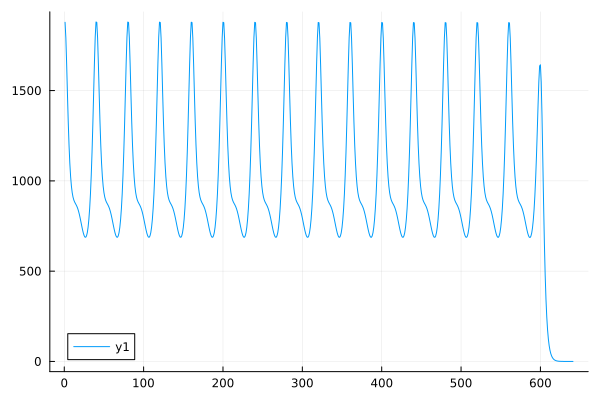

In [40]:
#can plot each diagonal element of the cost to go to see that it is periodic..
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [41]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 1878.27    -20.1674    62.6186    1595.77    1718.6     37.9723
  -20.1674    0.493183  -0.628399   -16.2136   -19.199   -0.395413
   62.6186   -0.628399   2.63074     53.4447    57.2065  -0.422925
 1595.77    -16.2136    53.4447    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9723   -0.395413  -0.422925    31.9983    34.3169   9.52339

[:, :, 2] =
 1791.63    126.901    53.8867    1481.15    1744.4     21.3351
  126.901     9.15194   3.84318    105.423    123.276    1.47771
   53.8867    3.84318   1.87429     44.7437    52.342   -0.117991
 1481.15    105.423    44.7437    1229.03    1437.68    17.2838
 1744.4     123.276    52.342     1437.68    1703.26    20.4682
   21.3351    1.47771  -0.117991    17.2838    20.4682   9.94356

[:, :, 3] =
 1647.31    231.473     41.7949    1360.5      1708.33    5.4943
  231.473    32.6689     5.87699    191.238     240.263   0.714937
   41.7949    5.87699

In [42]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V[:,:,2:end], dims=3)

#unstable manifold directions for 2 orbits worth of data 
unstable_directions_2 = cat(unstable_directions, unstable_directions[:, 2:end], dims=2)

6×81 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642321   -0.611253   -0.574696   -0.534157      -0.666939    -0.642321
  0.0139678   0.0196799   0.0247411   0.028827       0.00797907   0.0139678
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233299   0.0246806   0.0244821   0.0229327  …   0.0205333    0.0233299

In [43]:
#define the injection error, how far we are off from the initial condition of the halo 

#in cr3bp units 
x_initial_ref = [1e-6, 0, 0, 0, 1811.22e-6, 0]

#in km and days 
x_initial_ref_scaled = [x_initial_ref[1:3]*Earth_Moon.position_scale; x_initial_ref[4:6]*Earth_Moon.velocity_scale]

6-element Vector{Float64}:
   0.385
   0.0
   0.0
   0.0
 160.3354512468489
   0.0

In [44]:
#define the tube radii

#position radius
tube_pose_r = 1000

#velocity radius 
tube_vel_r = 1000

1000

In [45]:
#find the axis lengths for each of these P matrices

all_axes_length = zeros(6, 81) 

for i= 1:81

    P_i = V_2orbits[:,:,i]

    vals_i = eigen(P_i).values  

    axes_length_i = 2 ./ (sqrt.(vals_i))

    all_axes_length[:,i] = axes_length_i    

end

#velocity axes lenghts are much smaller than position since a larger deviation will lead to a larger cost in the long run

In [46]:
#this is the reference trajectory for 2 orbits starting at the beginning
reference_trajectory2 = [reference_trajectory reference_trajectory[:,2:end]]


reference_trajectory_half = cat(reference_trajectory[:,21:end], reference_trajectory[:,2:21], dims=2)

#this is the reference trajectory starting at the half, timesteo 21
reference_trajectory2_2 = cat(reference_trajectory_half, reference_trajectory_half[:,2:end], dims=2)

6×81 Matrix{Float64}:
      4.5462e5          4.54408e5  …       4.54408e5       4.5462e5
     -0.000105537   -5115.62            5115.62           -0.000105537
  -3158.04          -3131.97           -3131.97        -3158.04
     -7.34866e-5    -1134.14            1134.14           -7.34866e-5
 -13831.2          -13670.1           -13670.1        -13831.2
      1.01635e-6      140.265      …    -140.265           1.01635e-6

In [47]:
#this scales the axes on the cost-to-go ellipsoid. 
epsilon = 1e4

#parameter for the contingency constraint 
a = 1e-2

0.01

In [48]:
#define the state constraint type

#"euc" for the Euclidean ball constraint 
constraint_type = "euc"

#"ctg" for the cost-to-go ellipsoid constraint 
#constraint_type = "ctg"

"euc"

In [49]:
#one solve test
display("updating prob")
cons, X_1, U_1 = update_prob(Earth_Moon, x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, reference_trajectory2, constraint_type)
display("solving")
display(X_1)
Xm_1, Um_1 = solve_opt(cons, X_1, U_1, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 628…809

([0.385 6.123764173705394 … 527.6236743493567 678.6133802359469; 0.0 28.170111458406556 … -624.3450751044628 -734.3444089636881; … ; 160.3354512468489 -9.739266730413913 … -287.50411195612486 -302.80379442535667; 0.0 0.05129757661702902 … 19.61439474254752 27.199836529107504], [33.60348727070671 -57.30828582496266 … 2.3414709701844213e-13 2.1548490334975332e-13; -446.20410383066996 3.0467573061006115e-11 … -5.907458263252868e-15 -3.35992638054111e-11; 1.6428065394312422e-11 3.388909813066938e-12 … 5.773338290902798e-15 -1.2636055326244021e-11])

In [50]:
reference_trajectory 

6×41 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.21       0.000224533
  2286.77        2237.81    2094.64            2237.81    2286.77
     0.0          101.372    306.583           -101.374     -0.000128932
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.476      …     262.025     -7.52763e-6

In [51]:
Xm_1 

6×81 Matrix{Float64}:
   0.385   6.12376      12.2287     …   413.958      527.624     678.613
   0.0    28.1701       23.5736        -522.299     -624.345    -734.344
   0.0     0.00627803    0.0547916        0.219854     6.23194    14.9053
   0.0    26.4508        6.59319        262.713      353.056     463.296
 160.335  -9.73927     -14.2351        -260.683     -287.504    -302.804
   0.0     0.0512976     0.221527   …    12.9786      19.6144     27.1998

In [52]:
Um_1 

3×80 Matrix{Float64}:
   33.6035       -57.3083       -31.3928       …   2.34147e-13   2.15485e-13
 -446.204          3.04676e-11    8.71774e-11     -5.90746e-15  -3.35993e-11
    1.64281e-11    3.38891e-12    3.44757e-12      5.77334e-15  -1.26361e-11

In [53]:
#check the constraint satisfaction on the manifold constraint
# constraint_satisfied = zeros(N_h)

# for i=1:N_h
#     constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
# end

In [54]:
#all_Ad_1 and all_Bd_1 are the set of jacobians for two revoltions when we start at the beginning of the orbit 
#all_Ad_2 and all_Bd_2 are the set of jacobians for two revolutions when we start in the middle of the orbit 

all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,2:21], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,2:21], dims=3)

all_Ad_2 = cat(all_Ad_half, all_Ad_half[:,:,2:end], dims = 3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half[:,:,2:end], dims=3)

#also need to get the unstable directions and cost-to-go at the half point for two revoltions

#unstable directions is good. Need to fix V_2orbits
unstable_directions_half = cat(unstable_directions[:,21:end], unstable_directions[:,2:21], dims=2)

#P is for the 16 orbits. Need the one for just 1 orbit
V_half = cat(V[:,:,21:end], V[:,:,2:21], dims=3)


#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half[:,2:end], dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
  772.894   -287.342   -22.3345    1291.56     457.86    -21.3224
 -287.342    106.992     8.3504    -479.972   -170.378     7.5988
  -22.3345     8.3504    0.921634   -37.3475   -13.2516   -0.988617
 1291.56    -479.972   -37.3475    2160.83     760.832   -35.0727
  457.86    -170.378   -13.2516     760.832    278.841   -12.9023
  -21.3224     7.5988   -0.988617   -35.0727   -12.9023   16.147

[:, :, 2] =
  750.793   -317.889    -20.813     1278.42     417.519    -16.0993
 -317.889    134.751      8.84189   -541.27    -176.63       6.47161
  -20.813      8.84189    0.737207   -35.4356   -11.6217    -0.523837
 1278.42    -541.27     -35.4356    2178.83     706.937    -26.9208
  417.519   -176.63     -11.6217     706.937    240.677     -9.17272
  -16.0993     6.47161   -0.523837   -26.9208    -9.17272   16.901

[:, :, 3] =
  729.762   -344.647    -19.0513     1263.51     384.303    -10.6507
 -344.647    162.942      9.00809    -596.833   -181.007   

In [55]:
#run the MPC 

orbit_count = 0

#number of orbits you want to plan go for
orbit_num = 100

halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)

#save the solution of each solve 
solution_xm = zeros(6, 81, halforbit_num)
solution_um = zeros(6, 80, halforbit_num)

 
for i=1:halforbit_num

    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        #println("using jacobian set 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1 
        reference_traj_k = reference_trajectory2       
    else
        #println("using jacobian set 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
        reference_traj_k = reference_trajectory2_2
    end
    
    #the zeros is the bias 
    cons, X, U = update_prob(Earth_Moon, x_initial_ref_scaled, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, reference_traj_k, constraint_type)
        
    Xm, Um = solve_opt(cons, X, U,N_h)

    solution_xm = Xm
    solution_um = Um
    
    #get the optimal controls for half a period (20 for this example)
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    if i%2 != 0
        
        #print("from beginning")
        xtraj_halfperiod = integrate_halfperiod(Earth_Moon, reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #println("from half")

        #this Xm is the one that just got computed
        xtraj_halfperiod = integrate_halfperiod(Earth_Moon, reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref_scaled = all_optimal_Δx[:,end, orbit_count]

    
end  

Half Revolution solved: 1
Half Revolution solved: 2
Half Revolution solved: 3
Half Revolution solved: 4
Half Revolution solved: 5
Half Revolution solved: 6
Half Revolution solved: 7
Half Revolution solved: 8
Half Revolution solved: 9
Half Revolution solved: 10
Half Revolution solved: 11
Half Revolution solved: 12
Half Revolution solved: 13
Half Revolution solved: 14
Half Revolution solved: 15
Half Revolution solved: 16
Half Revolution solved: 17
Half Revolution solved: 18
Half Revolution solved: 19
Half Revolution solved: 20
Half Revolution solved: 21
Half Revolution solved: 22
Half Revolution solved: 23
Half Revolution solved: 24
Half Revolution solved: 25
Half Revolution solved: 26
Half Revolution solved: 27
Half Revolution solved: 28
Half Revolution solved: 29
Half Revolution solved: 30
Half Revolution solved: 31
Half Revolution solved: 32
Half Revolution solved: 33
Half Revolution solved: 34
Half Revolution solved: 35
Half Revolution solved: 36
Half Revolution solved: 37
Half Revol

In [56]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
   33.6035       -57.3083       -31.3928       …   2.66586e-12  -4.74667e-12
 -446.204          3.04676e-11    8.71774e-11     -1.64318e-10  -2.50582e-10
    1.64281e-11    3.38891e-12    3.44757e-12      6.0552e-11    4.24964e-13

[:, :, 2] =
 -8.08547e-10  -4.13002e-10  -9.81473e-10  …  -3.98416e-11  -3.11588e-11
 -1.38357e-9   -3.2847       -1.90563         -2.01552e-9   -6.20132e-10
  2.06966e-10   2.50453e-10   6.0831e-11      -5.69476e-13   1.35011e-10

[:, :, 3] =
 -1.87483e-10  -4.36997e-11  -2.38836e-11  …  -1.56525e-12  -1.42218e-12
 -0.07568      -6.58041e-11  -3.27187e-11      6.14282e-10   2.01786e-10
 -5.04169e-11  -2.06186e-13   7.44408e-16     -3.60601e-11  -3.32943e-11

;;; … 

[:, :, 198] =
 -0.671121    -2.49806e-12  -1.10423e-12  …   4.69347e-13   4.50863e-13
 -1.52124e-9  -1.38276e-9   -1.45096e-9      -1.81501e-13  -1.07816e-9
 -1.30662e-9  -1.29116e-9   -1.35275e-11      3.18252e-14  -1.31535e-9

[:, :, 199] =
 -0.211899   

In [57]:
#format the outputin 3D arrays. put all the half trajectory solutions together 
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [58]:
for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [59]:
#format to 2D arrays 
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))

all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

3×4000 Matrix{Float64}:
   33.6035       -57.3083       -31.3928       …   6.13722e-12   5.95801e-12
 -446.204          3.04676e-11    8.71774e-11     -3.87784e-12  -2.4947e-9
    1.64281e-11    3.38891e-12    3.44757e-12      5.30224e-13  -1.33899e-9

In [60]:
normz = zeros(4100)
for i=1:4100
    normz[i] = norm(all_Δxtraj[:,i])
end

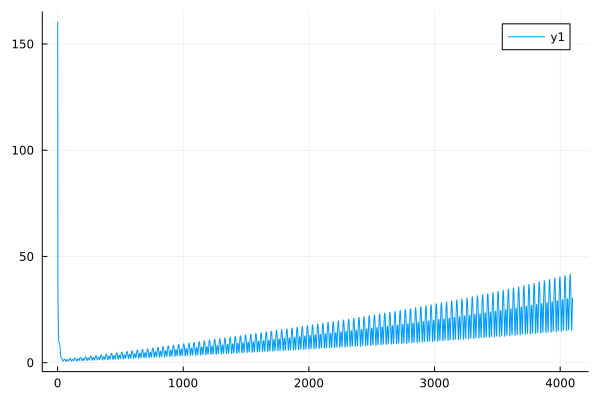

In [61]:
#state norm for the entire trajectory 
plot(normz )

In [62]:
#horizon for a 10 revolution trajectory in days
days_range = range(0,409, 410)

days = collect(days_range)*Δt

410-element Vector{Float64}:
   0.0
   0.3713042891751578
   0.7426085783503156
   1.1139128675254732
   1.4852171567006311
   1.856521445875789
   2.2278257350509465
   2.5991300242261044
   2.9704343134012623
   3.34173860257642
   ⋮
 148.89301995923827
 149.26432424841343
 149.6356285375886
 150.00693282676374
 150.3782371159389
 150.74954140511406
 151.12084569428922
 151.49214998346437
 151.86345427263953

In [63]:
Δt 

0.3713042891751578

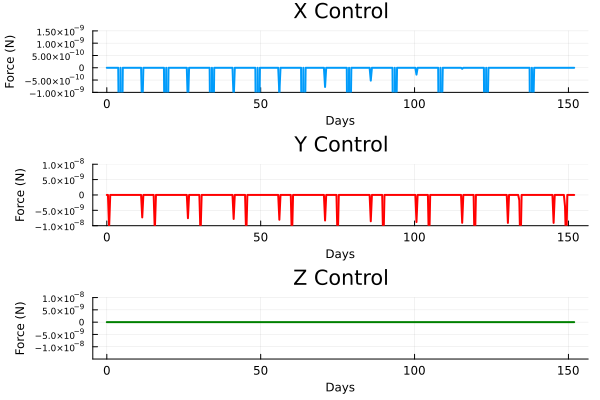

In [64]:
#this plots orbits 10-20

#for euclidean constraint 
# plot_range_x = (-1.5e-8, 1e-8)
# plot_range_y = (-1.5e-8, 1e-8)
# plot_range_z = (-1.5e-8, 1e-8)


#for ctg constraint 
plot_range_x = (-1e-9, 1.5e-9)
plot_range_y = (-1e-8, 1e-8)
plot_range_z = (-1.5e-8, 1e-8)


plot1 = plot(days, all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range_x, title= "X Control")
plot2 = plot(days, all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range_y, title= "Y Control", linecolor="red")
plot3 = plot(days , all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range_z, title= "Z Control", linecolor="green")


plot_layout = @layout [a;
                       b; 
                       c]

control1020 = plot(plot1, plot2, plot3, layout=plot_layout, legend=false, xlabel="Days", xlabelfontsize=8, ylabel="Force (N)", ylabelfontsize=8, ytickfontsize = 6)

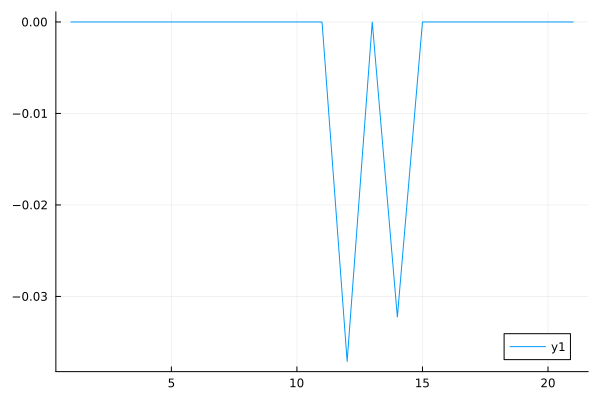

In [65]:
plot(all_utraj[1,410:430]) 

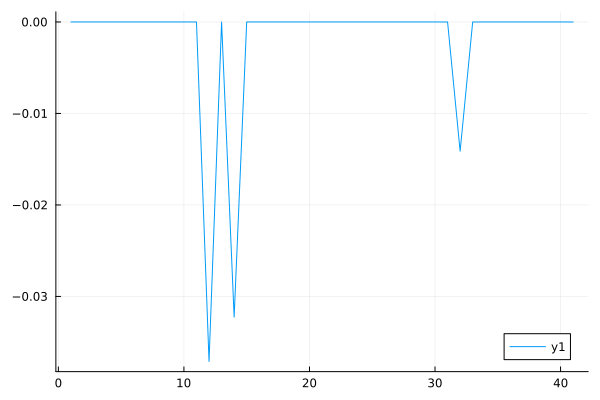

In [66]:
plot(all_utraj[1, 410:450])

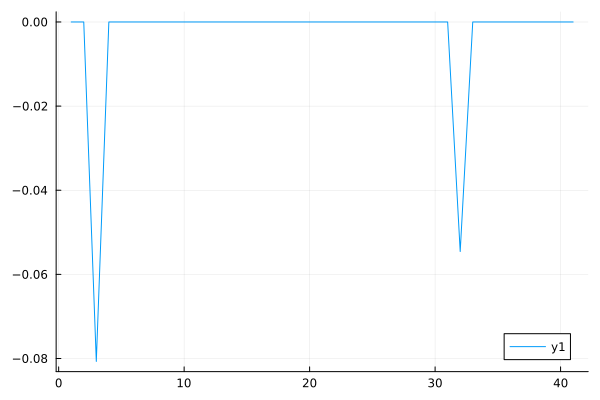

In [67]:
plot(all_utraj[2, 410:450])

In [68]:
all_utraj[2, 410:429] 

20-element Vector{Float64}:
  5.253084878410586e-10
  8.353691248765067e-10
 -0.08069311166242293
 -5.910259070407083e-9
 -2.664373678279101e-10
 -5.929926631100004e-11
 -3.01396129800789e-11
 -5.221414204886057e-10
 -1.2677433374898566e-10
  2.6330373633920816e-9
 -5.8082938618119544e-11
  5.04621193369323e-10
  1.3708734864252787e-9
  6.997145680179157e-10
 -1.503554747794216e-9
 -2.3690864897442504e-12
 -1.9888089274651494e-12
 -1.6816103635700465e-12
 -1.4678331784660738e-12
 -1.3562250170992806e-12

In [69]:
all_utraj[1, 410:429]

20-element Vector{Float64}:
  1.00840355738394e-12
  7.28446055600978e-13
  2.2368221111627403e-13
 -4.840397547292051e-13
 -1.3970397361795214e-12
 -2.5548793704456164e-12
 -4.0631003185789545e-12
 -6.136710661263134e-12
 -9.184041028212026e-12
 -3.2365273883632244e-11
 -1.813838313311665e-11
 -0.037108529417269324
 -8.082642293889842e-11
 -0.03226196378637396
 -1.061529755633941e-11
 -6.443085613040152e-12
 -5.81032570955127e-12
 -5.249815952113579e-12
 -4.552516136058619e-12
 -3.805939035299337e-12

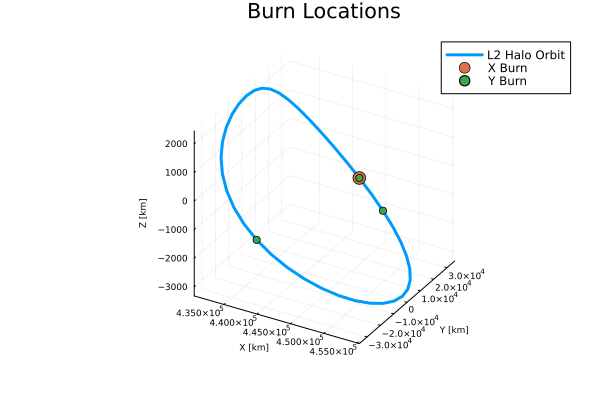

In [70]:
#burn locations plot
burn_locations = plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], linewidth = 3, title= "Burn Locations", label = "L2 Halo Orbit", legend=:topright)
scatter!([reference_trajectory[1,12]],[reference_trajectory[2,12]],[reference_trajectory[3,12]], label="X Burn", markersize = 7, xlabel="X [km]", ylabel = "                 Y [km]", zlabel="Z [km]", 
ylabelfontsize=6, ytickfontsize = 6, xlabelfontsize=6, xtickfontsize = 6, zlabelfontsize=6, ztickfontsize = 6)
scatter!([reference_trajectory[1,12], reference_trajectory[1,14], reference_trajectory[1,31]],[reference_trajectory[2,12], reference_trajectory[2,14], reference_trajectory[2,31]],[reference_trajectory[3,12],reference_trajectory[3,14], reference_trajectory[3,31]], label="Y Burn", markersize = 4)

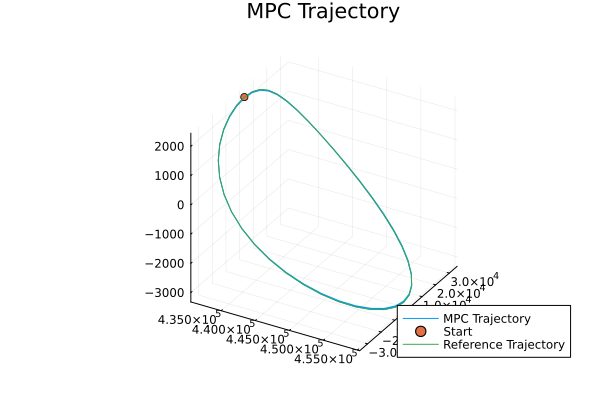

In [71]:
#plot the 100 orbits

plot(all_xtraj[1,:], all_xtraj[2,:], all_xtraj[3,:], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

In [72]:
#this is already in units of km/(days)^2
scaled_control = all_utraj

3×4000 Matrix{Float64}:
   33.6035       -57.3083       -31.3928       …   6.13722e-12   5.95801e-12
 -446.204          3.04676e-11    8.71774e-11     -3.87784e-12  -2.4947e-9
    1.64281e-11    3.38891e-12    3.44757e-12      5.30224e-13  -1.33899e-9

In [73]:
#integrate over the timestep to get the velocity cost in km/day
x_cost = sum(abs.(scaled_control[1,:]))*(Δt)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt)

1.3513458310957884e-6

In [74]:
#velocity cost in m/s
#dividing by 86400 to get into seconds bc currently it is in days

#units are good (checked in simulation_test)
x_cost_ms = x_cost*(1e3/86400)
y_cost_ms = y_cost*(1e3/86400)
z_cost_ms = z_cost*(1e3/86400)

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

0.6430920754113827

2.2757491812502577

1.5640576748793846e-8

In [75]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms  

2.9188412723022172

In [76]:
cost_per_rev = all_cost/orbit_num

0.029188412723022174

In [77]:
#Exclude the first 10 timesteps to fix the injection error
x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt) *(1e3/86400)
y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt) *(1e3/86400)
z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt) *(1e3/86400)

display(x_cost_good)
display(y_cost_good)
display(z_cost_good)

0.11600586940375769

0.2599262764925542

1.563057103315174e-8

In [78]:
# #cost for 95 revs
all_cost_good = x_cost_good + y_cost_good + z_cost_good 

0.3759321615268829

In [79]:
#get the cost per year 

year_constant = 365/sol_t_final[end] 

year_cost = cost_per_rev*year_constant 

0.7173207362868168

In [80]:
#check the constraint for the manifold direction 
constraint_check = zeros(4100)
for k=1:100
    for i=1:41

        constraint_check[41*(k-1)+i] = dot(unstable_directions[:,i], all_Δxtraj[:, 41*(k-1)+i]) #> 0 

    end
end

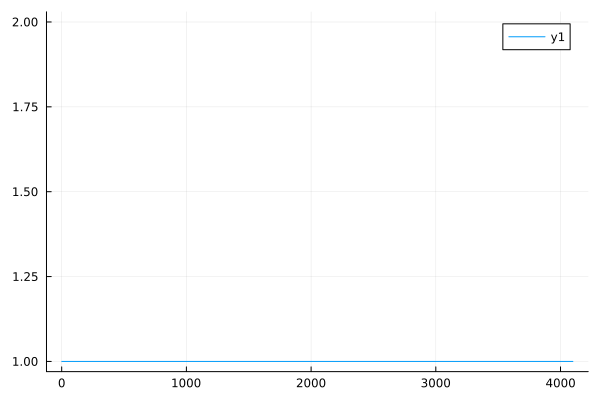

In [81]:
#first timestep not included in the constraint 
plot(constraint_check[2:end].>0)

In [82]:
all_utraj 

3×4000 Matrix{Float64}:
   33.6035       -57.3083       -31.3928       …   6.13722e-12   5.95801e-12
 -446.204          3.04676e-11    8.71774e-11     -3.87784e-12  -2.4947e-9
    1.64281e-11    3.38891e-12    3.44757e-12      5.30224e-13  -1.33899e-9

In [83]:
all_utraj[:,1]  

3-element Vector{Float64}:
   33.60348727070671
 -446.20410383066996
    1.6428065394312422e-11

In [84]:
all_utraj[:,2]  

3-element Vector{Float64}:
 -57.30828582496266
   3.0467573061006115e-11
   3.388909813066938e-12

In [85]:
all_utraj[:,3]  

3-element Vector{Float64}:
 -31.392803418596937
   8.717742010648918e-11
   3.447567399981482e-12

In [86]:
all_xtraj 

6×4100 Matrix{Float64}:
     4.3125e5      4.31273e5      4.3135e5  …      4.31269e5      4.31252e5
     0.0        5803.39       11367.2          -5778.16          -3.21016
  2286.77       2237.81        2094.69          2207.68        2256.45
     0.0         127.826        313.177         -101.242          0.0495661
 15809.4       15355.0        14531.6          15363.9        15648.4
     0.0        -261.974       -504.254     …    259.756          1.23782

In [87]:
#save the 100-rev trajectory of the solve
#writedlm("xtraj_earth_moon_euclidean.txt", all_xtraj) 

In [88]:
#save the reference in the /refs folder 
#writedlm("reference_earth_moon.txt", reference_trajectory) 